In [109]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from tabulate import tabulate

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4733 entries, 0 to 4732
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     4733 non-null   object 
 1   Open     4733 non-null   float64
 2   High     4733 non-null   float64
 3   Low      4733 non-null   float64
 4   Close    4733 non-null   float64
 5   Volume   4733 non-null   int64  
 6   OpenInt  4733 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 259.0+ KB


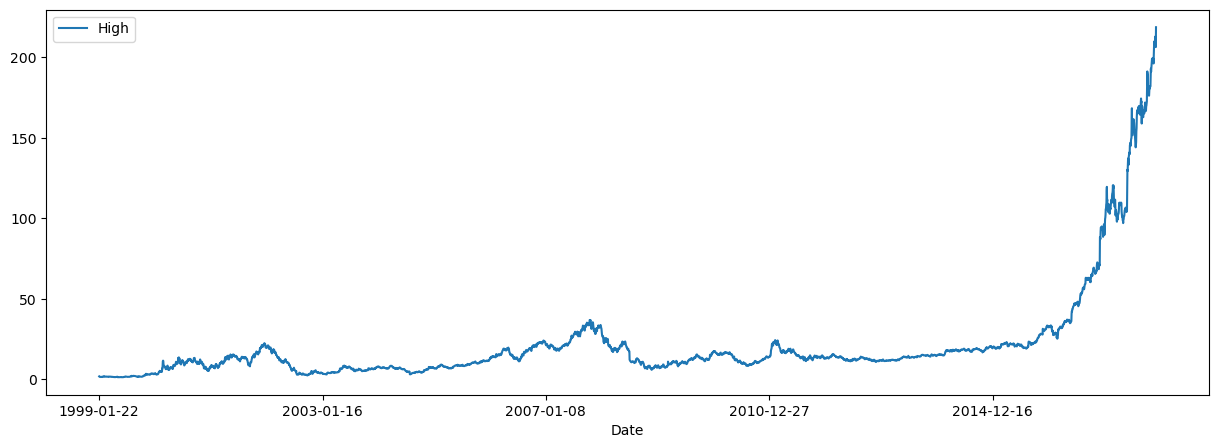

In [110]:

df = pd.read_csv("C:/Users/micha/Desktop/113deep/HW4/nvda.us.txt")

df.columns
df.info()
df.isnull().sum()
df = df.dropna()
df.shape
df.describe()
# 畫出高價變化趨勢
plot = df.plot('Date', 'High', figsize=(15, 5))
plt.show()

In [111]:
def create_sequences(input_data, output_data, window_size, step):
    sequences = []
    labels = []
    for i in range(0, len(input_data) - window_size, step):
        if not np.isnan(output_data[i + window_size]) and not np.isnan(input_data[i:(i + window_size)].sum()):
            sequences.append(input_data[i:(i + window_size)])
            labels.append(output_data[i + window_size])
    return np.array(sequences), np.array(labels)


In [112]:
# ====== LSTM 模型 ======
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

train_loss_records = {}
# ========== 不同 window/step，標準化 vs 未標準化比較 ==========
window_step_configs = [
    (10, 15),
    (8, 15),
    (10, 10),
    (3, 3)
]

window_step_results = []

In [113]:
for window_size, step in window_step_configs:
    for normalize_flag in [False, True]:
        print(f"\n[Window/Step] Training window_size={window_size}, step={step}, normalize={normalize_flag}")

        features = df[['Open', 'High', 'Low', 'Close']]
        labels = df['High'].shift(-1)

        if normalize_flag:
            features = (features - features.mean()) / features.std()

        X, y = create_sequences(features.values, labels.values, window_size, step)

        ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int)
        x_test = X[ind]
        y_test = y[ind]
        all_ind = np.arange(len(X))
        remains_ind = np.delete(all_ind, ind)

        X = X[remains_ind]
        y = y[remains_ind]

        ind = np.random.permutation(len(X))
        X = X[ind]
        y = y[ind]
        split_point = int(X.shape[0]*0.8)

        x_train = X[:split_point]
        y_train = y[:split_point]
        x_val = X[split_point:]
        y_val = y[split_point:]

        x_train = torch.from_numpy(x_train).float()
        y_train = torch.from_numpy(y_train).float()
        x_val = torch.from_numpy(x_val).float()
        y_val = torch.from_numpy(y_val).float()
        x_test = torch.from_numpy(x_test).float()
        y_test = torch.from_numpy(y_test).float()

        batch_size = 32

        train_dataset = TensorDataset(x_train, y_train)
        val_dataset = TensorDataset(x_val, y_val)
        test_dataset = TensorDataset(x_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        model = LSTMModel(input_dim=4, hidden_dim=500, num_layers=2, output_dim=1).cuda()

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0)

        train_losses = []
        val_losses = []
        epochs = 100

        for epoch in tqdm(range(epochs)):
            model.train()
            total_loss = 0.0
            for features_batch, labels_batch in train_loader:
                features_batch = features_batch.cuda()
                labels_batch = labels_batch.cuda()
                outputs = model(features_batch).squeeze(-1)
                loss = criterion(outputs, labels_batch)
                total_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            lr_scheduler.step()

            avg_train_loss = total_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for features_batch, labels_batch in val_loader:
                    features_batch = features_batch.cuda()
                    labels_batch = labels_batch.cuda()
                    outputs = model(features_batch).squeeze(-1)
                    loss = criterion(outputs, labels_batch)
                    val_loss += loss.item()
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

        model.eval()

        pred_value = []
        actual_value = []

        with torch.no_grad():
            for features_batch, labels_batch in test_loader:
                features_batch = features_batch.cuda()
                outputs = model(features_batch).squeeze(-1)
                pred_value.append(outputs.cpu())
                actual_value.append(labels_batch)

        pred_value = torch.cat(pred_value)
        actual_value = torch.cat(actual_value)

        mse = F.mse_loss(pred_value, actual_value)

        window_step_results.append({
            'Window Size': window_size,
            'Step Size': step,
            'Normalized': normalize_flag,
            'Test MSE': mse.item()
        })

        train_loss_records[f'{window_size}-{step}-norm={normalize_flag}'] = (train_losses, val_losses)

# 顯示 window/step 結果
window_step_df = pd.DataFrame(window_step_results)
print("\n=== Window/Step Normalization Comparison ===")
print(tabulate(window_step_df, headers='keys', tablefmt='github', showindex=True))



[Window/Step] Training window_size=10, step=15, normalize=False


  0%|          | 0/100 [00:00<?, ?it/s]


[Window/Step] Training window_size=10, step=15, normalize=True


  0%|          | 0/100 [00:00<?, ?it/s]


[Window/Step] Training window_size=8, step=15, normalize=False


  0%|          | 0/100 [00:00<?, ?it/s]


[Window/Step] Training window_size=8, step=15, normalize=True


  0%|          | 0/100 [00:00<?, ?it/s]


[Window/Step] Training window_size=10, step=10, normalize=False


  0%|          | 0/100 [00:00<?, ?it/s]


[Window/Step] Training window_size=10, step=10, normalize=True


  0%|          | 0/100 [00:00<?, ?it/s]


[Window/Step] Training window_size=3, step=3, normalize=False


  0%|          | 0/100 [00:00<?, ?it/s]


[Window/Step] Training window_size=3, step=3, normalize=True


  0%|          | 0/100 [00:00<?, ?it/s]


=== Window/Step Normalization Comparison ===
|    |   Window Size |   Step Size | Normalized   |   Test MSE |
|----|---------------|-------------|--------------|------------|
|  0 |            10 |          15 | False        |  343.2     |
|  1 |            10 |          15 | True         |  340.24    |
|  2 |             8 |          15 | False        |  503.707   |
|  3 |             8 |          15 | True         |  304.46    |
|  4 |            10 |          10 | False        |  191.136   |
|  5 |            10 |          10 | True         |  150.045   |
|  6 |             3 |           3 | False        |    7.18008 |
|  7 |             3 |           3 | True         |    6.73344 |


In [114]:
# ========== 🟢 Part 2：不同 Feature 組合，標準化 vs 未標準化比較 ==========
feature_combinations = [
    ['Open', 'High', 'Low', 'Close'],
    ['Open', 'High', 'Low', 'Close', 'Volume'],
    ['High', 'Low', 'Close'],
    ['Open', 'Close', 'Volume'],
    ['High', 'Volume']
]

feature_results = []

fixed_window_size = 3
fixed_step = 3

for feature_set in feature_combinations:
    for normalize_flag in [False, True]:
        print(f"\n[Feature Set] Training features={feature_set}, normalize={normalize_flag}")

        features = df[feature_set]
        labels = df['High'].shift(-1)

        if normalize_flag:
            features = (features - features.mean()) / features.std()

        X, y = create_sequences(features.values, labels.values, window_size=fixed_window_size, step=fixed_step)

        ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int)
        x_test = X[ind]
        y_test = y[ind]
        all_ind = np.arange(len(X))
        remains_ind = np.delete(all_ind, ind)

        X = X[remains_ind]
        y = y[remains_ind]

        ind = np.random.permutation(len(X))
        X = X[ind]
        y = y[ind]
        split_point = int(X.shape[0]*0.8)

        x_train = X[:split_point]
        y_train = y[:split_point]
        x_val = X[split_point:]
        y_val = y[split_point:]

        x_train = torch.from_numpy(x_train).float()
        y_train = torch.from_numpy(y_train).float()
        x_val = torch.from_numpy(x_val).float()
        y_val = torch.from_numpy(y_val).float()
        x_test = torch.from_numpy(x_test).float()
        y_test = torch.from_numpy(y_test).float()

        batch_size = 32

        train_dataset = TensorDataset(x_train, y_train)
        val_dataset = TensorDataset(x_val, y_val)
        test_dataset = TensorDataset(x_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        model = LSTMModel(input_dim=len(feature_set), hidden_dim=500, num_layers=2, output_dim=1).cuda()

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0)

        train_losses = []
        val_losses = []
        epochs = 100

        for epoch in tqdm(range(epochs)):
            model.train()
            total_loss = 0.0
            for features_batch, labels_batch in train_loader:
                features_batch = features_batch.cuda()
                labels_batch = labels_batch.cuda()
                outputs = model(features_batch).squeeze(-1)
                loss = criterion(outputs, labels_batch)
                total_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            lr_scheduler.step()

            avg_train_loss = total_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for features_batch, labels_batch in val_loader:
                    features_batch = features_batch.cuda()
                    labels_batch = labels_batch.cuda()
                    outputs = model(features_batch).squeeze(-1)
                    loss = criterion(outputs, labels_batch)
                    val_loss += loss.item()
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

        model.eval()

        pred_value = []
        actual_value = []

        with torch.no_grad():
            for features_batch, labels_batch in test_loader:
                features_batch = features_batch.cuda()
                outputs = model(features_batch).squeeze(-1)
                pred_value.append(outputs.cpu())
                actual_value.append(labels_batch)

        pred_value = torch.cat(pred_value)
        actual_value = torch.cat(actual_value)

        mse = F.mse_loss(pred_value, actual_value)

        feature_results.append({
            'Features': str(feature_set),
            'Normalized': normalize_flag,
            'Test MSE': mse.item()
        })

        train_loss_records[f'{feature_set}-norm={normalize_flag}'] = (train_losses, val_losses)

# 顯示 feature 結果
feature_df = pd.DataFrame(feature_results)
print("\n=== Feature Combination Normalization Comparison ===")
print(tabulate(feature_df, headers='keys', tablefmt='github', showindex=True))


[Feature Set] Training features=['Open', 'High', 'Low', 'Close'], normalize=False


  0%|          | 0/100 [00:00<?, ?it/s]


[Feature Set] Training features=['Open', 'High', 'Low', 'Close'], normalize=True


  0%|          | 0/100 [00:00<?, ?it/s]


[Feature Set] Training features=['Open', 'High', 'Low', 'Close', 'Volume'], normalize=False


  0%|          | 0/100 [00:00<?, ?it/s]


[Feature Set] Training features=['Open', 'High', 'Low', 'Close', 'Volume'], normalize=True


  0%|          | 0/100 [00:00<?, ?it/s]


[Feature Set] Training features=['High', 'Low', 'Close'], normalize=False


  0%|          | 0/100 [00:00<?, ?it/s]


[Feature Set] Training features=['High', 'Low', 'Close'], normalize=True


  0%|          | 0/100 [00:00<?, ?it/s]


[Feature Set] Training features=['Open', 'Close', 'Volume'], normalize=False


  0%|          | 0/100 [00:00<?, ?it/s]


[Feature Set] Training features=['Open', 'Close', 'Volume'], normalize=True


  0%|          | 0/100 [00:00<?, ?it/s]


[Feature Set] Training features=['High', 'Volume'], normalize=False


  0%|          | 0/100 [00:00<?, ?it/s]


[Feature Set] Training features=['High', 'Volume'], normalize=True


  0%|          | 0/100 [00:00<?, ?it/s]


=== Feature Combination Normalization Comparison ===
|    | Features                                   | Normalized   |   Test MSE |
|----|--------------------------------------------|--------------|------------|
|  0 | ['Open', 'High', 'Low', 'Close']           | False        |    6.47029 |
|  1 | ['Open', 'High', 'Low', 'Close']           | True         |    7.24242 |
|  2 | ['Open', 'High', 'Low', 'Close', 'Volume'] | False        | 1043.32    |
|  3 | ['Open', 'High', 'Low', 'Close', 'Volume'] | True         |    7.15588 |
|  4 | ['High', 'Low', 'Close']                   | False        |    7.67471 |
|  5 | ['High', 'Low', 'Close']                   | True         |    7.20411 |
|  6 | ['Open', 'Close', 'Volume']                | False        | 1044       |
|  7 | ['Open', 'Close', 'Volume']                | True         |    7.63133 |
|  8 | ['High', 'Volume']                         | False        | 1043.47    |
|  9 | ['High', 'Volume']                         | True         |

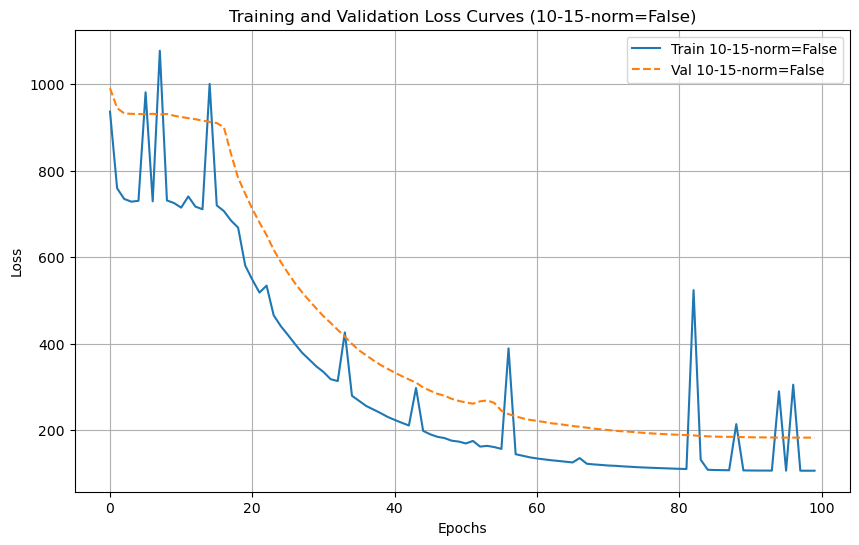

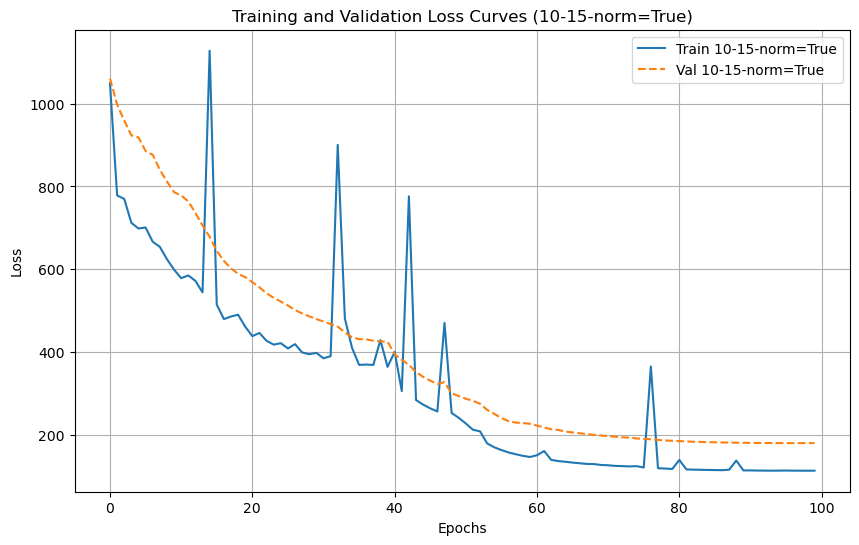

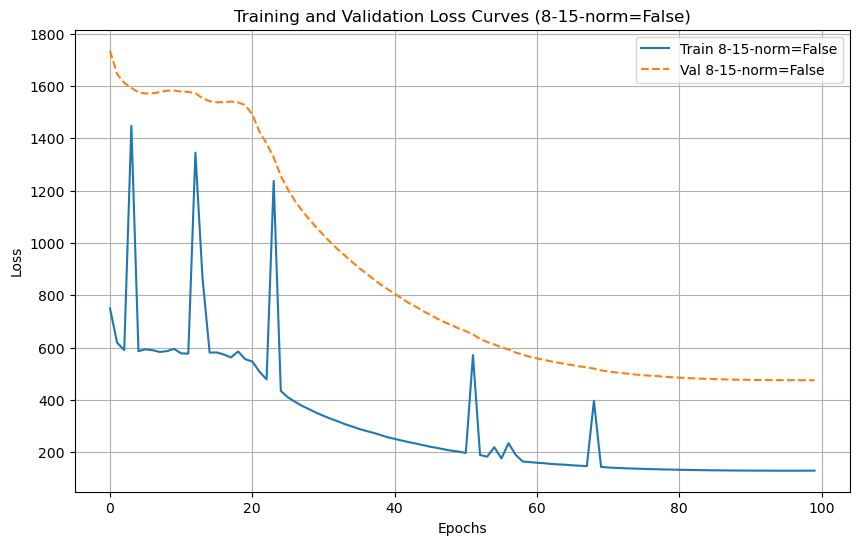

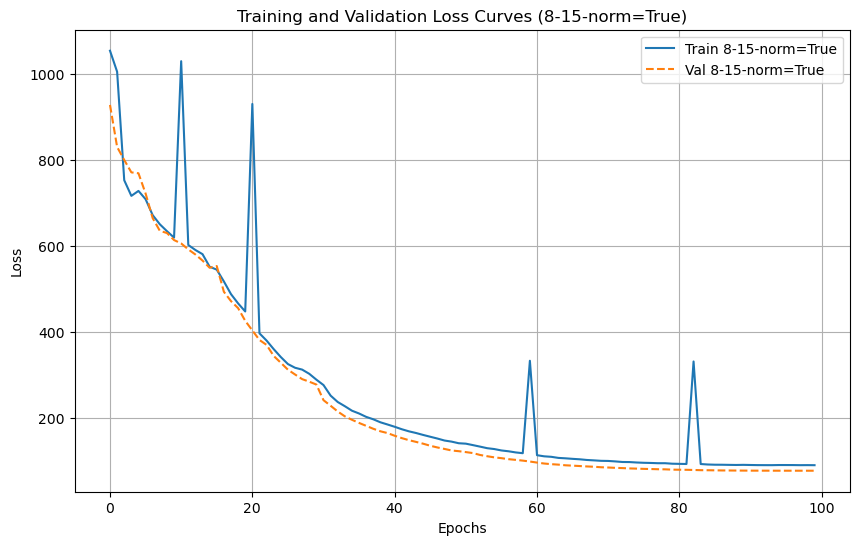

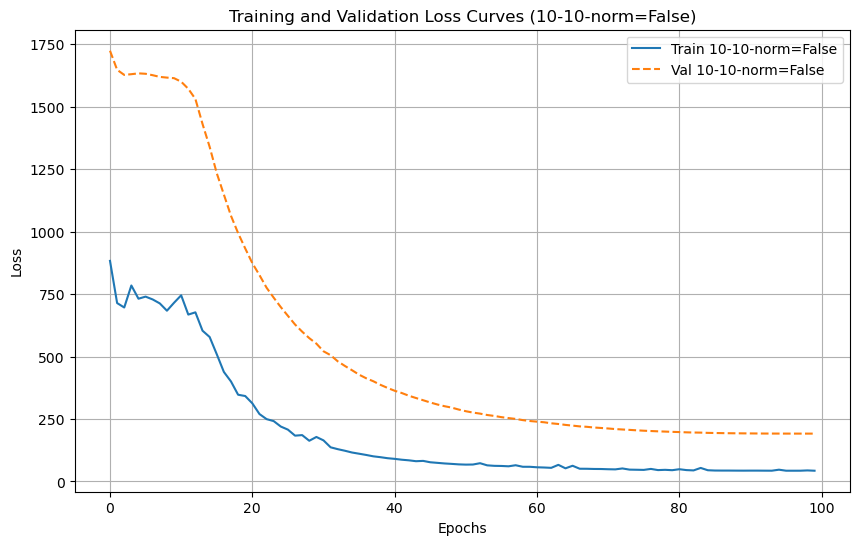

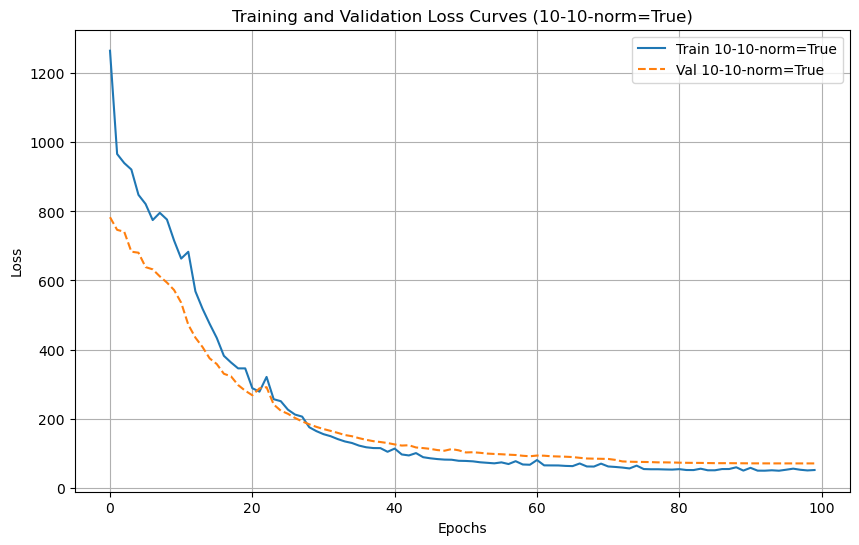

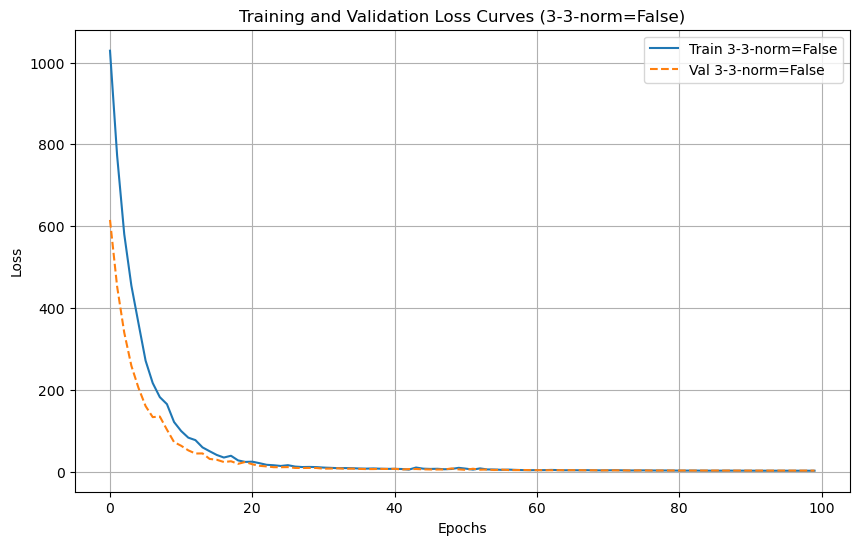

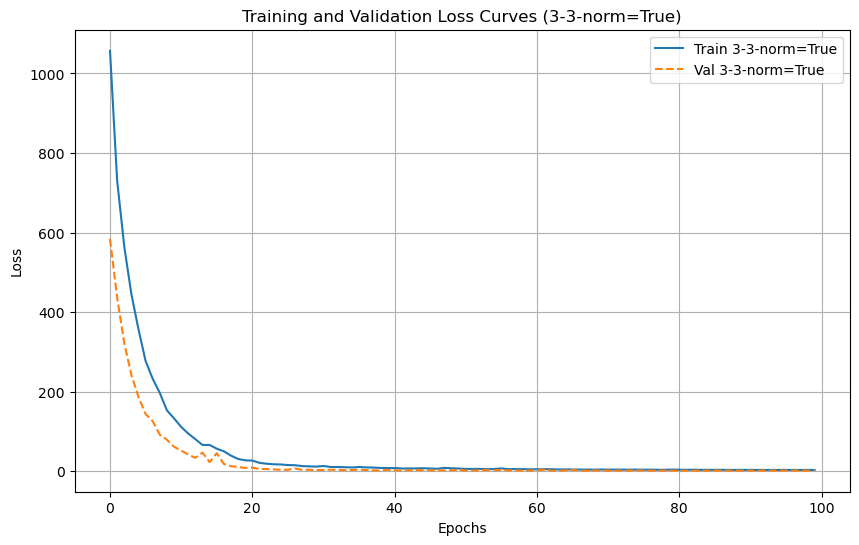

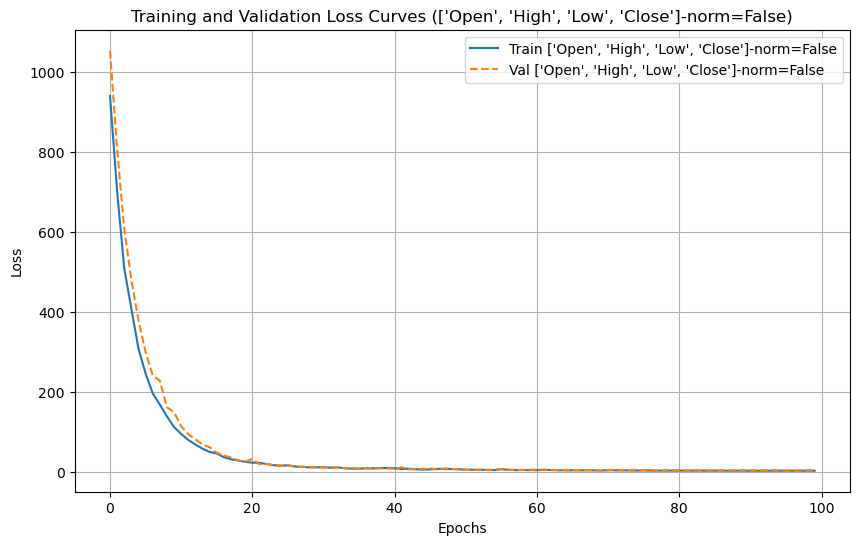

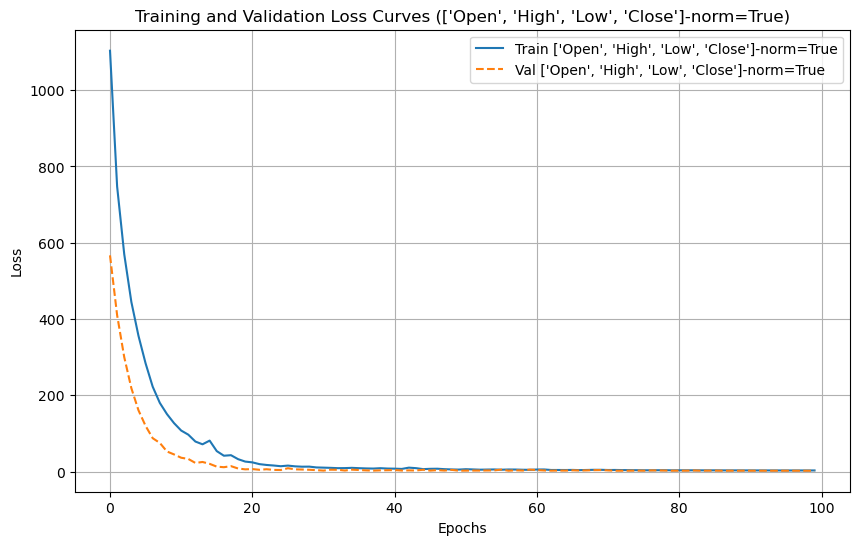

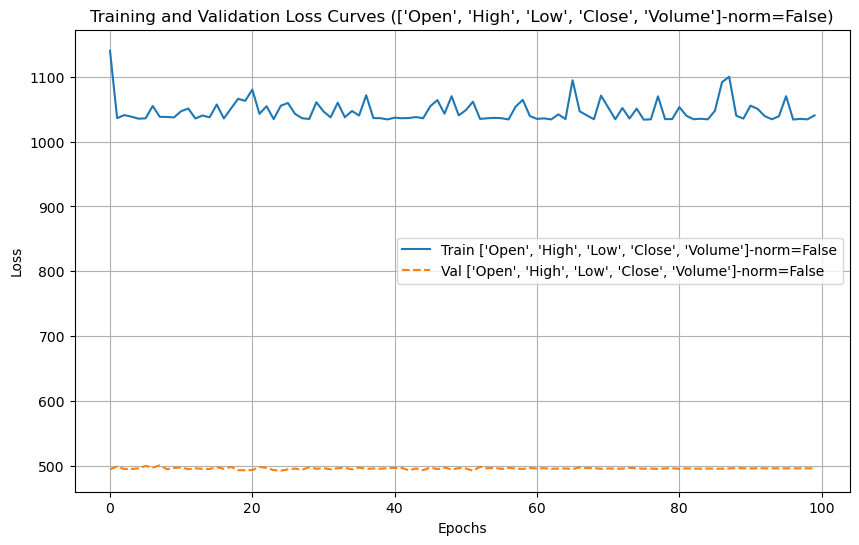

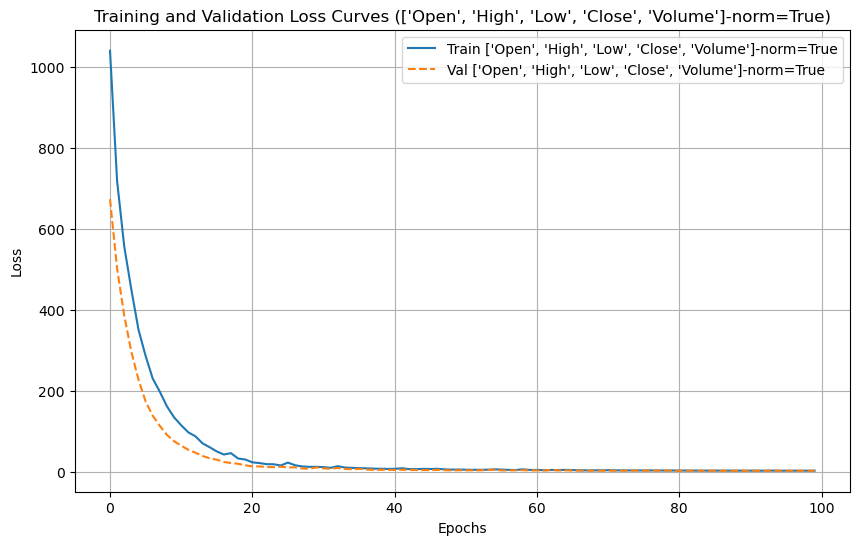

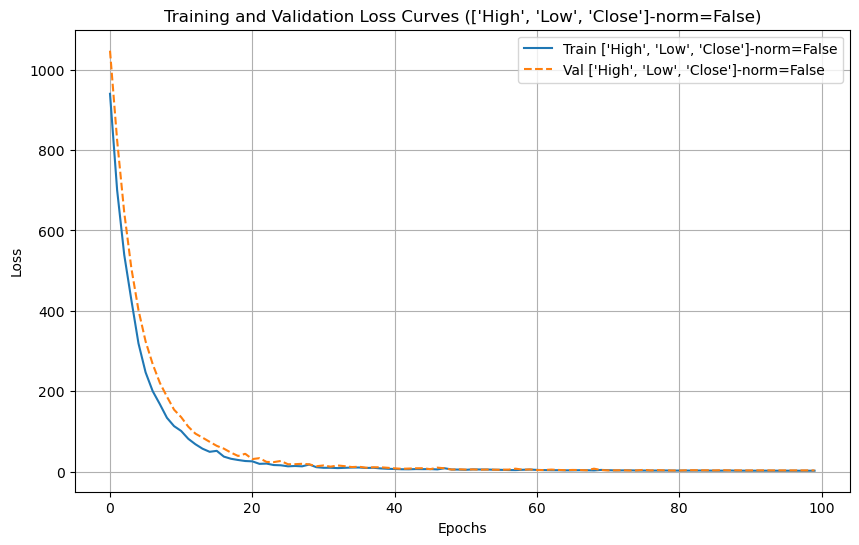

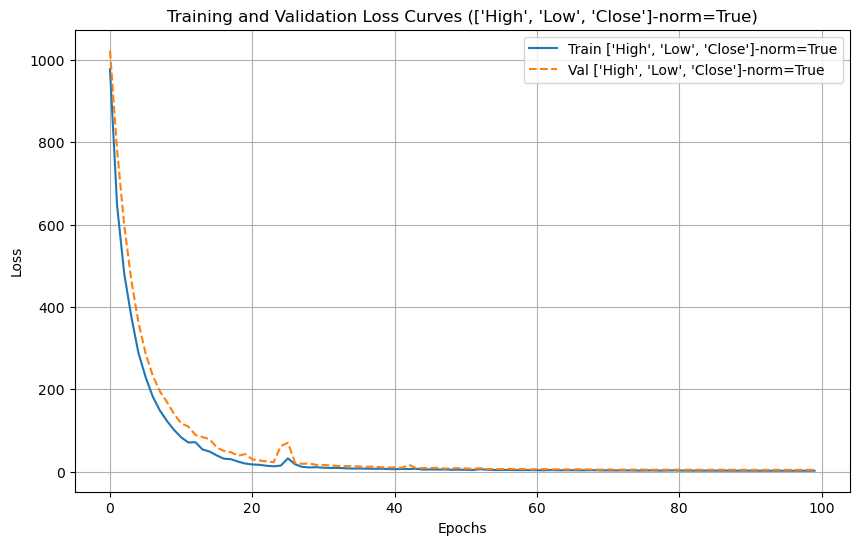

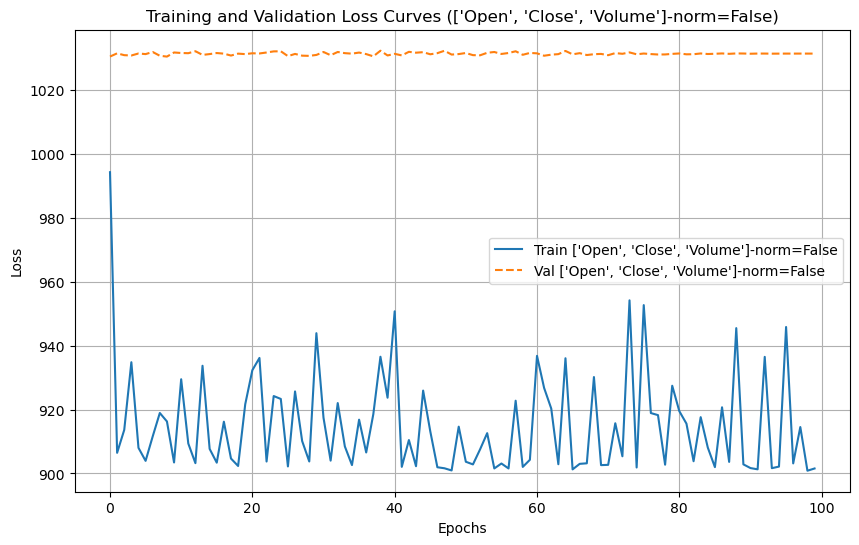

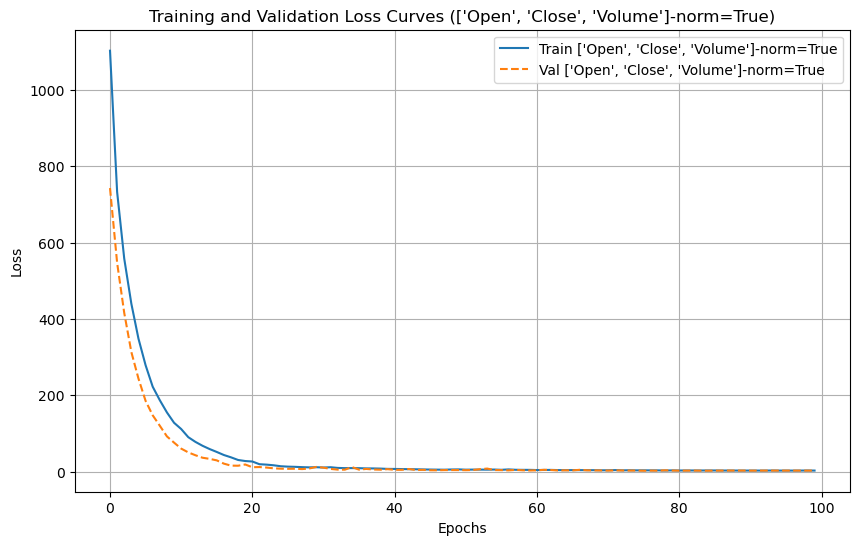

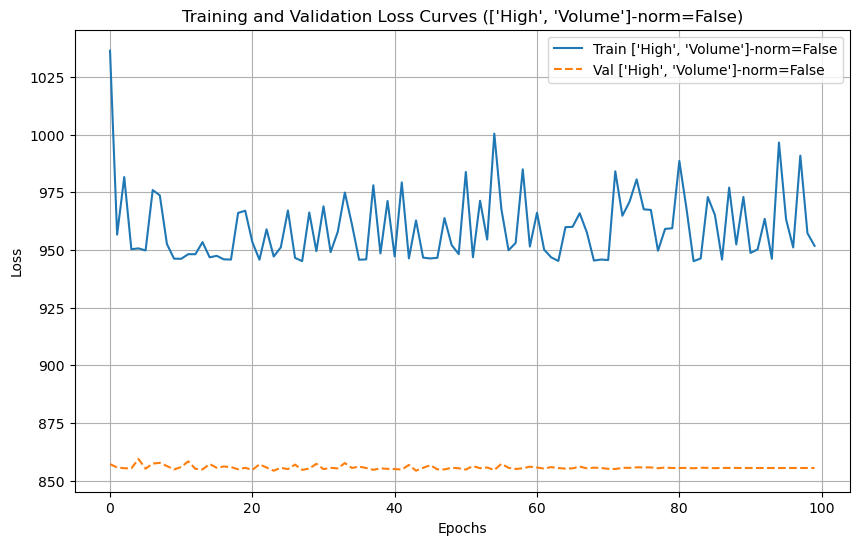

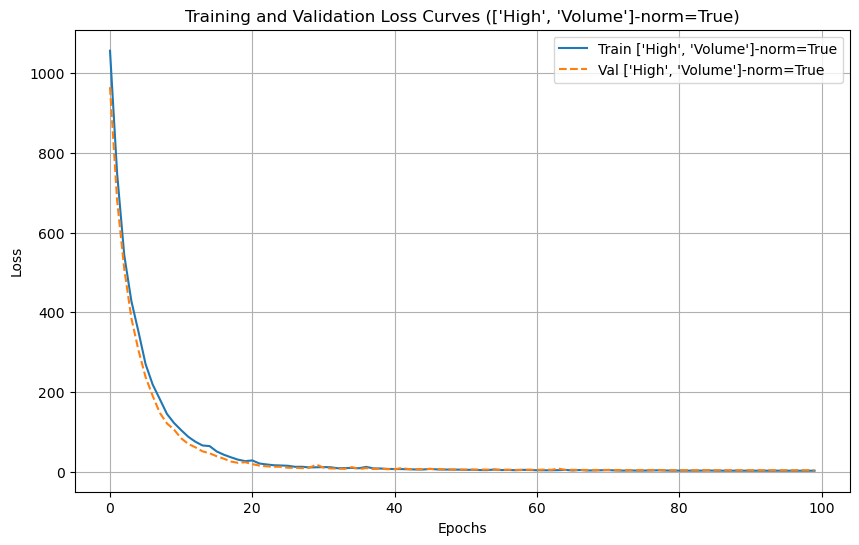

In [115]:
# ====== 畫Loss曲線 ======
for key, (train_losses, val_losses) in train_loss_records.items():
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label=f'Train {key}')
    plt.plot(val_losses, linestyle='--', label=f'Val {key}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss Curves ({key})')
    plt.legend()
    plt.grid(True)
    plt.show()
